In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [12]:
import matplotlib.pyplot as plt

from datetime import date, timedelta
import timeit, functools

from tqdm.auto import tqdm

import pickle
import os

import numpy as np
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

In [3]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)

print(start_date, current_date)

2023-06-01 2023-06-22 2028-06-20


In [4]:
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
lock_target = 0.3
sector_duration=360
num_mc = 10
forecast_length_yrs_vec = range(1,10)

In [5]:
# Time Numpy
np_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length = forecast_length_yrs*365
    
    end_date = current_date + timedelta(days=forecast_length)
    np_offline_data = np_sim.get_offline_data(token, start_date, current_date, end_date)

    t = timeit.Timer(
        functools.partial(np_sim.run_simple_sim_offline, 
                          start_date,
                          current_date,
                          forecast_length,
                          rr_val,
                          rbp_val,
                          fpr_val,
                          sector_duration,
                          np_offline_data
                         ),
    )
    np_speeds.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/9 [00:00<?, ?it/s]

In [7]:
# verify we are in 32bit mode for jax and perform a jit compile to time things properly
forecast_length = 720
rbp = jnp.ones(forecast_length) * rbp_val
rr = jnp.ones(forecast_length) * rr_val
fpr = jnp.ones(forecast_length) * fpr_val

end_date = current_date + timedelta(days=forecast_length)
    
jax_offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
jax_results = sim.run_sim(rbp, rr, fpr, lock_target, start_date, current_date, forecast_length, sector_duration, jax_offline_data)

In [8]:
jax_results['network_locked'].dtype

dtype('float32')

In [9]:
# Time JAX
jax_speeds = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length = forecast_length_yrs*365

    rbp = jnp.ones(forecast_length) * rbp_val
    rr = jnp.ones(forecast_length) * rr_val
    fpr = jnp.ones(forecast_length) * fpr_val

    end_date = current_date + timedelta(days=forecast_length)
    jax_offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

    t = timeit.Timer(
        functools.partial(sim.run_sim, 
                          rbp,
                          rr,
                          fpr,
                          lock_target,
                          start_date,
                          current_date,
                          forecast_length,
                          sector_duration,
                          jax_offline_data
                         ),
    )
    jax_speeds.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
# save to temporary file
tmp_dir = '/tmp/time_jax'
os.makedirs(tmp_dir, exist_ok=True)
with open(os.path.join(tmp_dir, 'first_set.pkl'), 'wb') as f:
    pickle.dump({'np_speed': np_speeds, 'jax_32bit_speeds': jax_speeds}, f)

In [ ]:
# restart kernel so we can run jax in 64 bit mode
%reset -f
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
# try 64-bit
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from datetime import date, timedelta
import timeit, functools

from tqdm.auto import tqdm

import pickle
import os
from IPython.core.display import HTML

import numpy as np
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C

In [3]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)

print(start_date, current_date)

2023-06-01 2023-06-22


In [6]:
rbp_val = 6
rr_val = 0.6
fpr_val = 0.6
lock_target = 0.3
sector_duration=360
num_mc = 10
forecast_length_yrs_vec = range(1,10)

In [7]:
# verify we are in 64bit mode for jax and perform a jit compile to time things properly
forecast_length = 720
rbp = jnp.ones(forecast_length) * rbp_val
rr = jnp.ones(forecast_length) * rr_val
fpr = jnp.ones(forecast_length) * fpr_val

end_date = current_date + timedelta(days=forecast_length)
    
jax_offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
jax_results = sim.run_sim(rbp, rr, fpr, lock_target, start_date, current_date, forecast_length, sector_duration, jax_offline_data)

In [8]:
jax_results['network_locked'].dtype

dtype('float64')

In [9]:
# Time JAX
jax_speeds_64bit = []
for forecast_length_yrs in tqdm(forecast_length_yrs_vec):
    forecast_length = forecast_length_yrs*365

    rbp = jnp.ones(forecast_length) * rbp_val
    rr = jnp.ones(forecast_length) * rr_val
    fpr = jnp.ones(forecast_length) * fpr_val

    end_date = current_date + timedelta(days=forecast_length)
    jax_offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

    t = timeit.Timer(
        functools.partial(sim.run_sim, 
                          rbp,
                          rr,
                          fpr,
                          lock_target,
                          start_date,
                          current_date,
                          forecast_length,
                          sector_duration,
                          jax_offline_data
                         ),
    )
    jax_speeds_64bit.append(t.timeit(num_mc)/num_mc)

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
# load 32 bit results
tmp_dir = '/tmp/time_jax'
with open(os.path.join(tmp_dir, 'first_set.pkl'), 'rb') as f:
    res = pickle.load(f)

np_speeds = np.asarray(res['np_speed'])
jax_32bit_speeds = np.asarray(res['jax_32bit_speeds'])
jax_64bit_speeds = np.asarray(jax_speeds_64bit)

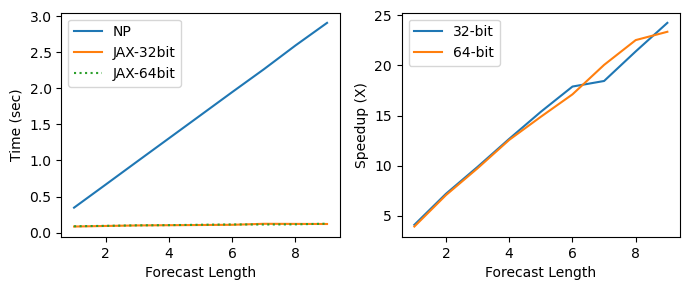

In [11]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(forecast_length_yrs_vec, np_speeds, label='NP')
plt.plot(forecast_length_yrs_vec, jax_32bit_speeds, label='JAX-32bit')
plt.plot(forecast_length_yrs_vec, jax_64bit_speeds, label='JAX-64bit', linestyle=':')
plt.xlabel('Forecast Length')
plt.ylabel('Time (sec)')
plt.legend()

plt.subplot(1,2,2)
plt.plot(forecast_length_yrs_vec, np.asarray(np_speeds)/np.asarray(jax_32bit_speeds), label='32-bit')
plt.plot(forecast_length_yrs_vec, np.asarray(np_speeds)/np.asarray(jax_64bit_speeds), label='64-bit')
plt.xlabel('Forecast Length')
plt.ylabel('Speedup (X)')
plt.legend()

plt.tight_layout()